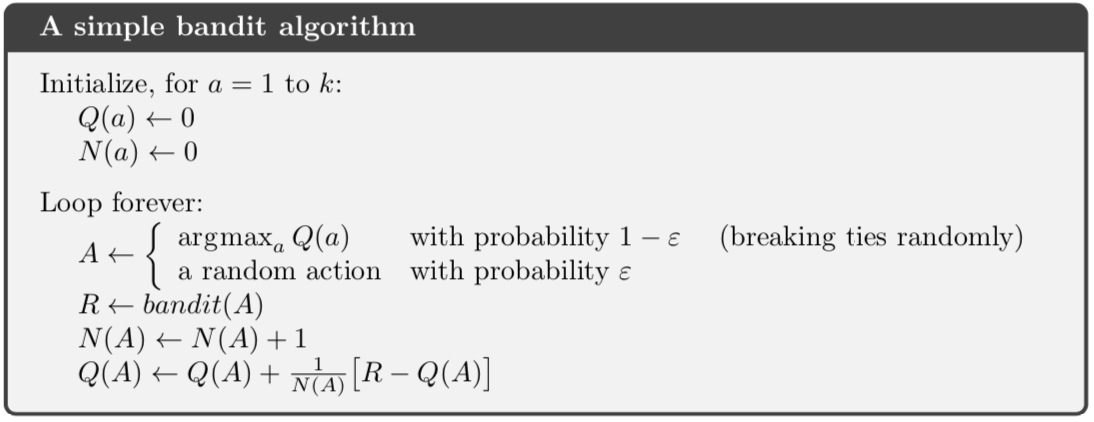

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image
from functools import reduce

Image("2.4_A simple bandit algorithm.png")

Let's assume a 10-armed testbed (k=10). <br>
The action values are selected according to a normal distribution with mean $q_*(A_t)$ and variance 1.

In [2]:
class KBandit:
    
    def __init__(self, k=10, e=0):
        self.k = k
        self.epsilon = e
        
        self.true_rewards = (np.random.rand(k) - 0.5) * 3
        self.estimated_rewards = np.zeros(k)
        
        self.n_action = np.zeros(k)
        self.run_reward = np.array([])

    def get_action_rewards(self):
        return np.random.normal(self.true_rewards, 1)
    
    def perform_action(self):
        select_greedy = np.random.binomial(1, 1-self.epsilon)
        greedy_index = np.argmax(self.estimated_rewards)

        if select_greedy == 1:
            index = greedy_index
            
        else:
            k_arms = np.arange(self.k)
            ngreedy_indices = np.delete(k_arms, greedy_index)
            index = np.random.choice(ngreedy_indices, 1)[0]

        reward = self.get_action_rewards()[index]
        return index, reward

    def perform_run(self, steps=1000):

        for step in range(steps):
            idx, reward = self.perform_action()

            # Update estimated reward
            self.n_action[idx] += 1
            action_step_size = 1 / self.n_action[idx]
            
            e_reward = self.estimated_rewards[idx]
            e_error = reward - e_reward
            
            new_e_reward = e_reward + action_step_size * e_error
            self.estimated_rewards[idx] = new_e_reward

            # Update overall run reward
            n = np.sum(self.n_action)
            run_step_size = 1 / n
            
            try:
                run_av_reward = self.run_reward[-1]
            except IndexError:
                run_av_reward = 0
                
            r_error = reward - run_av_reward
            
            new_av_reward = run_av_reward + run_step_size * r_error
            self.run_reward = np.append(self.run_reward, new_av_reward)

        return pd.Series(self.run_reward)

In [3]:
runs = 2000

for run in range(runs):
    
    greedy = KBandit()
    near_greedy1 = KBandit(e=0.01)
    near_greedy2 = KBandit(e=0.1)
    
    greedy_run = greedy.perform_run(steps=2000)
    ngreedy1_run = near_greedy1.perform_run(steps=2000)
    ngreedy2_run = near_greedy2.perform_run(steps=2000)
    
    if run == 0:
        greedy_arr = np.array([greedy_run])
        ngreedy1_arr = np.array([ngreedy1_run])
        ngreedy2_arr = np.array([ngreedy2_run])
    else:
        greedy_arr = np.concatenate((greedy_arr, [greedy_run.values]), axis=0)
        ngreedy1_arr = np.concatenate((ngreedy1_arr, [ngreedy1_run.values]), axis=0)
        ngreedy2_arr = np.concatenate((ngreedy2_arr, [ngreedy2_run.values]), axis=0)

In [10]:
g = pd.DataFrame(np.mean(greedy_arr, axis=0))
ng1 = pd.DataFrame(np.mean(ngreedy1_arr, axis=0))
ng2 = pd.DataFrame(np.mean(ngreedy2_arr, axis=0))

kbandit = reduce(lambda x, y: pd.concat([x, y], sort=False, axis=1), [g, ng1, ng2])

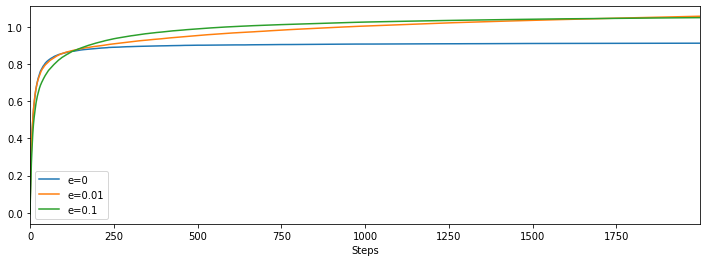

In [17]:
kbandit.columns = ['e=0', 'e=0.01', 'e=0.1']
ax = kbandit.plot(figsize=(12,4))
_ = ax.set_xlabel('Steps')